In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import ssd.imaging as imaging
import ssd.tools as tools
import ssd.prior_box as pb
from ssd.data_augmenter import DataAugmenter
from ssd.generator import Generator
from ssd.bbox_codec import BBoxCodec, LargestObjClassCodec, LargestObjBoxCodec, LargestObjBoxAndClassCodec
from ssd.detection import Detection

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load prepared GroundTruth boxes
gtb = pickle.load(open('data/pascal_voc_2012.p', 'rb'))

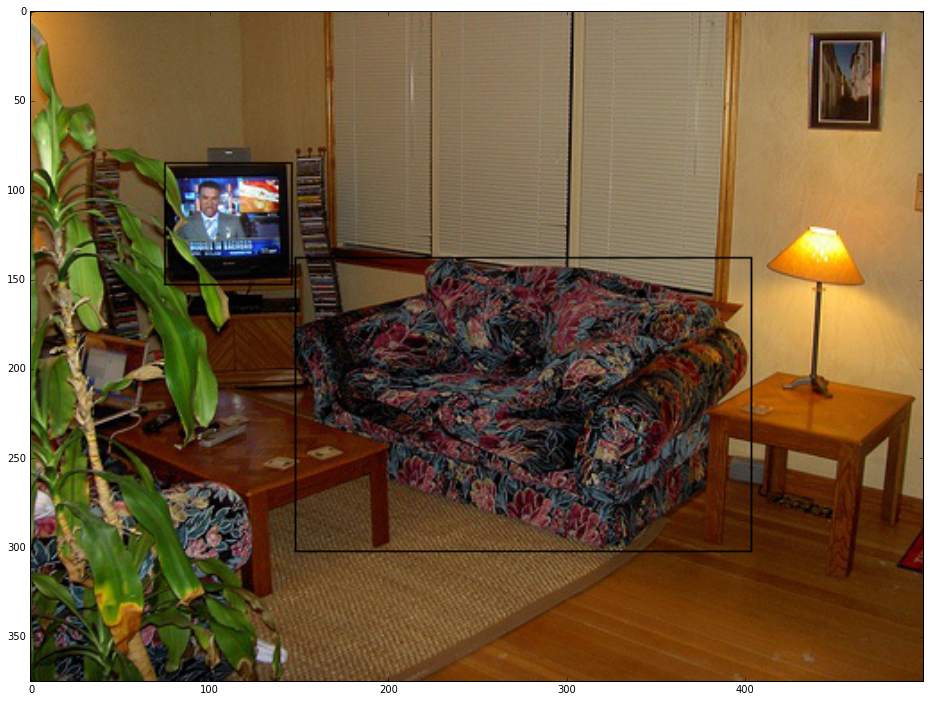

In [3]:
img_dir = '../datasets/voc2012/VOCtrainval_11-May-2012/JPEGImages/'
#test_img_file = '2011_001771.jpg' #boat, persons
#test_img_file = '2010_001311.jpg' #dog
#test_img_file = '2007_000032.jpg'
#test_img_file = '2007_000256.jpg' #plane
#test_img_file = '2007_000464.jpg' #cow
#test_img_file = '2007_002462.jpg' #train
#test_img_file = '2007_002953.jpg' #bottle, tv
test_img_file = '2007_001149.jpg' #sofa, tv
#test_img_file = '2007_001558.jpg' #persons
#test_img_file = '2007_002088.jpg' #cow
#test_img_file = '2007_003143.jpg' #car

test_y = gtb[test_img_file].copy()

target_img_w, target_img_h = 300, 300
target_img_size = (target_img_w, target_img_h)

# Load test image and show it with boxes
test_img = imaging.load_img(img_dir + test_img_file)
tools.draw_boxes(test_img, test_y, log=False)

## Test DataAugmenter

Drawing 2 boxes
(125,32), (380, 197)
(51,0), (122, 47)


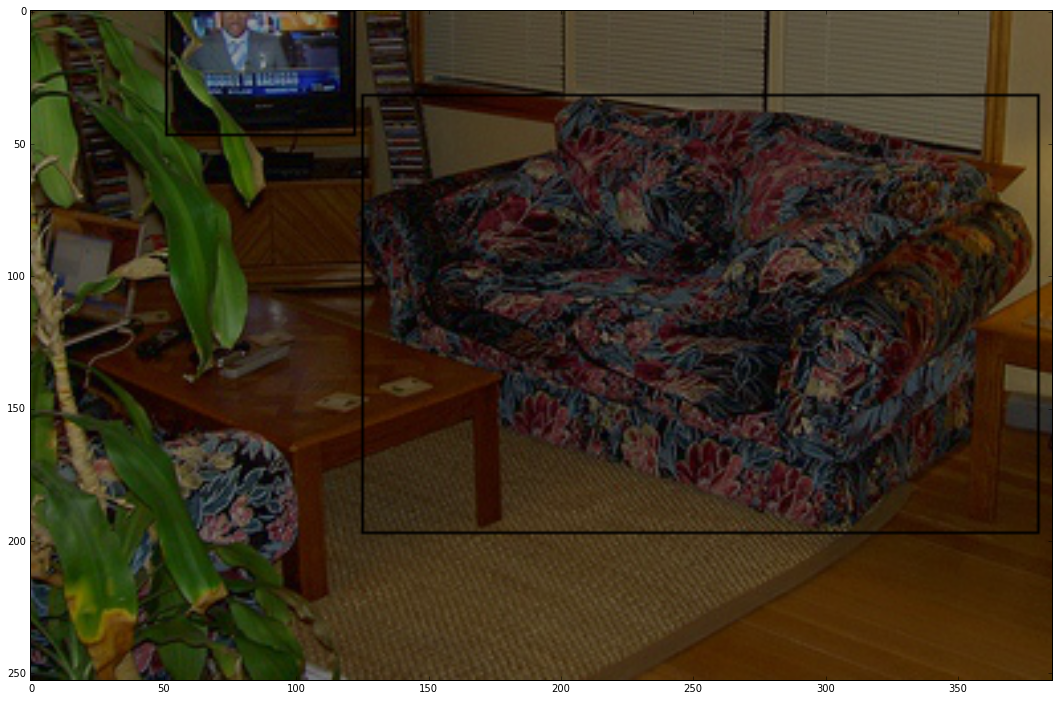

In [4]:
# Augment data
augmenter = DataAugmenter()
augmented_img, augmented_y = augmenter.augment(test_img, test_y)
tools.draw_boxes(augmented_img, augmented_y, log=True)
#print(augmented_img)

## Test Generator

In [5]:
num_classes = 21
encode_variances = True
img_file_names = [test_img_file]#list(gtb.keys())[:1]
print(img_file_names)


['2007_001149.jpg']


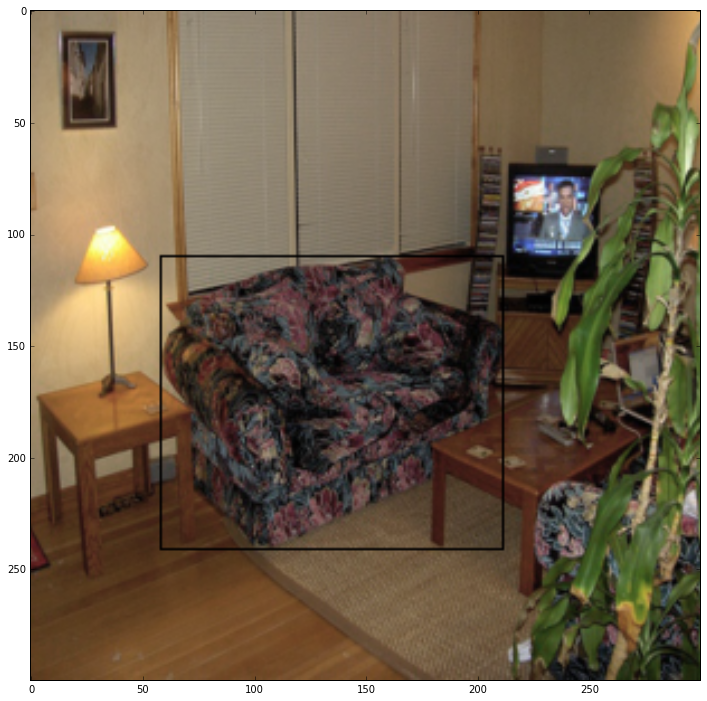

In [6]:
############## Test LargestObjBoxAndClassCodec ##############

bbox_codec = LargestObjBoxAndClassCodec()
gen = Generator(gtb, img_dir, target_img_size, augmenter, bbox_codec)#, do_augment=False)

# get first batch
x_batch, y_batch = next(gen.flow(img_file_names, batch_size=4))

for img, y in zip(x_batch, y_batch):
    img = np.copy(img)
    y = np.array([y])
    
    img = imaging.denormalize_img(img)
    
    tools.draw_boxes(img, y, log=False)   

In [7]:
############## Test BBoxCodec ##############

prior_boxes = pb.create_prior_boxes_vect(target_img_w, target_img_h, pb.default_config, pb.default_prior_variance)
bbox_codec = BBoxCodec(prior_boxes, num_classes, iou_threshold=0.5, encode_variances=encode_variances)
gen = Generator(gtb, img_dir, target_img_size, augmenter, bbox_codec)#, do_augment=False)
detector = Detection(num_classes, target_img_size, bbox_codec, out_nms_top_k=100, out_conf_threshold=0.9)

# get first batch
x_batch, y_batch = next(gen.flow(img_file_names, batch_size=4))


total_matched_boxes: 979.0


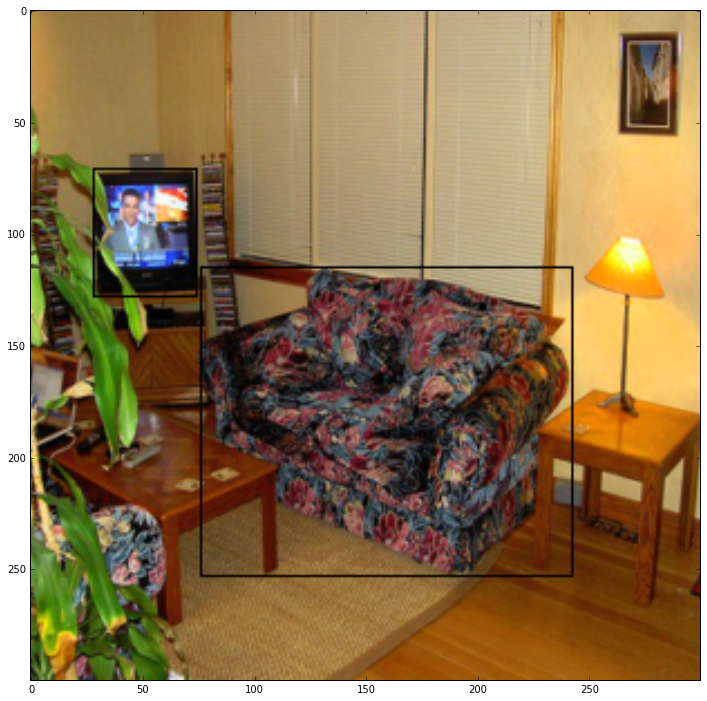

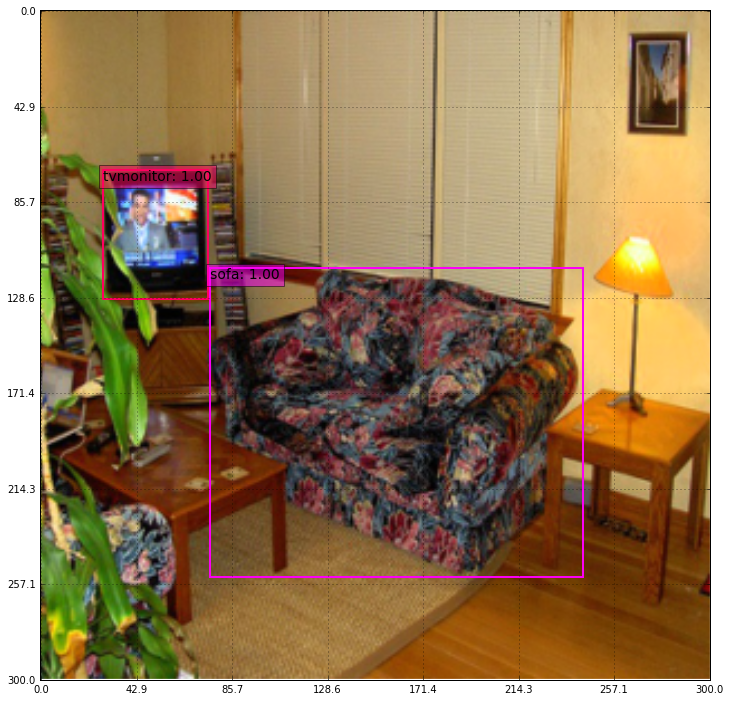

In [8]:
#print(y_batch)
total_matched_boxes = np.sum(y_batch[:, :, -8])
print('total_matched_boxes: {}'.format(total_matched_boxes))

for img, y in zip(x_batch, y_batch):
    img = np.copy(img)
    y = np.copy(y)
    
    # denormalize
    img = imaging.denormalize_img(img)
    
    # store matched indices mask
    matched_indices = y[:, -8] == 1
    
    # copy priobox data
    y[:, -8:] = np.copy(prior_boxes)
    
    # retain only matched bboxes
    y = y[matched_indices]
    
    #print('y:{}'.format(y.shape))
    
    # check decode
    bboxes = bbox_codec.decode(y)
    #print('bboxes:{}'.format(bboxes))
    tools.draw_boxes(img.astype(np.uint8), bboxes, log=False)   
    
    # check predictions
    predictions = detector.out(np.array([img]), np.array([y]))
    tools.show_bboxes(img.astype(np.uint8), predictions[0], num_classes)
    
    
